In [1]:
!pip install ctgan

In [19]:
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

df_real = pd.read_csv(r'D:\dow\project\data\processed_iot_dataset.csv') 

sensor_cols = [
    'Normalized_Temp', 'Normalized_Vibration', 'Normalized_Pressure',
    'Normalized_Voltage', 'Normalized_Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]
time_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_real.columns]
sensor_id_col = 'Sensor_ID'

df_real = df_real[df_real['Fault_Status'] == 1].reset_index(drop=True)
valid_sensor_ids = df_real[(df_real[sensor_id_col] >= 100) & (df_real[sensor_id_col] <= 200)][sensor_id_col].unique()
df_real = df_real[df_real[sensor_id_col].isin(valid_sensor_ids)].reset_index(drop=True)

scaler = MinMaxScaler()
df_real_scaled = df_real.copy()
df_real_scaled[sensor_cols] = scaler.fit_transform(df_real[sensor_cols])

n_sample = 5000
synthetic = []

for fault_type in [1, 2, 3]:
    print(f"\n- Sinh dữ liệu cho Fault_Type = {fault_type}")
    df_ft = df_real_scaled[df_real_scaled['Fault_Type'] == fault_type].reset_index(drop=True)
    num_train = len(df_ft)
    if num_train < 100:
        print(f"Fault_Type {fault_type}: số mẫu thật quá ít ({num_train}). Bỏ qua.")
        continue

    all_synth = []
    # Đa seed tăng đa dạng
    for seed in [42, 99, 2024]:
        np.random.seed(seed)
        categorical_cols = [
            col for col in df_ft.columns
            if (df_ft[col].dtype == 'object' or df_ft[col].nunique() < 20)
            and col not in time_cols + [sensor_id_col, 'Fault_Type']
        ]
        train_cols = [col for col in df_ft.columns if col not in time_cols]
        ctgan = CTGAN(epochs=200)
        ctgan.fit(df_ft[train_cols], categorical_cols)
        synth = ctgan.sample(n_sample // 3)
        synth['Fault_Type'] = fault_type

        # Gán Sensor_ID, time theo phân phối gốc của từng loại lỗi
        sid_dist = df_ft[sensor_id_col].value_counts(normalize=True)
        synth[sensor_id_col] = np.random.choice(
            sid_dist.index, size=len(synth), p=sid_dist.values
        )
        for col in [c for c in time_cols if c in df_ft]:
            val_dist = df_ft[col].value_counts(normalize=True)
            synth[col] = np.random.choice(val_dist.index, size=len(synth), p=val_dist.values)

        # Đưa về giá trị gốc
        synth[sensor_cols] = scaler.inverse_transform(synth[sensor_cols])

        # Clip giá trị về đúng min-max data thật (cực ngắn gọn)
        for col in sensor_cols:
            min_val = df_real[col].min()
            max_val = df_real[col].max()
            synth[col] = synth[col].clip(lower=min_val, upper=max_val)
        synth = synth[synth[sensor_id_col].isin(valid_sensor_ids)]
        synth['Fault_Status'] = 1
        all_synth.append(synth)

    synth_all = pd.concat(all_synth, ignore_index=True)
    print(f"Tổng mẫu sau sinh, lọc, gộp seed: {len(synth_all)}")
    print(synth_all[sensor_cols].describe().T[['min', 'max', 'mean', 'std']])
    synthetic.append(synth_all)

df_gan = pd.concat(synthetic, ignore_index=True)

col_order = (
    time_cols + [sensor_id_col] + sensor_cols +
    ['Fault_Type', 'Fault_Status']
)
df_gan = df_gan[[col for col in col_order if col in df_gan.columns]]

df_gan.to_csv(r'D:\dow\project\data\ctgan_synthetic_balanced_final.csv', index=False)
print(f"\nĐã sinh {len(df_gan)} mẫu CTGAN tối ưu!")



- Sinh dữ liệu cho Fault_Type = 1
Tổng mẫu sau sinh, lọc, gộp seed: 4998
                           min       max      mean       std
Normalized_Temp       0.213570  0.872145  0.544087  0.129600
Normalized_Vibration  0.207836  0.822099  0.490524  0.119445
Normalized_Pressure   0.131956  0.777612  0.466821  0.125329
Normalized_Voltage    0.207631  0.866486  0.541299  0.134061
Normalized_Current    0.199061  0.822227  0.522211  0.119642
FFT_Feature1          0.000215  0.999982  0.510900  0.309831
FFT_Feature2          0.000084  0.999984  0.468998  0.284321
Anomaly_Score         0.000047  0.999926  0.525837  0.300510

- Sinh dữ liệu cho Fault_Type = 2
Tổng mẫu sau sinh, lọc, gộp seed: 4998
                           min       max      mean       std
Normalized_Temp       0.213570  0.872145  0.550847  0.133693
Normalized_Vibration  0.207836  0.822099  0.467956  0.123623
Normalized_Pressure   0.131956  0.777612  0.455051  0.123259
Normalized_Voltage    0.207631  0.866486  0.564915  0.12526

In [ ]:
# --------------------------------------------

In [26]:
# 1. Đọc file dữ liệu gốc và file GAN đã sinh
df_real = pd.read_csv('D:\dow\project\data\processed_iot_dataset.csv')
df_gan = pd.read_csv('D:\dow\project\data\ctgan_synthetic_balanced_final.csv')

sensor_cols = [
    'Normalized_Temp', 'Normalized_Vibration', 'Normalized_Pressure',
    'Normalized_Voltage', 'Normalized_Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]

print(f"{'Sensor':<25} | {'Min Real':>10} | {'Max Real':>10} | {'Min GAN':>10} | {'Max GAN':>10}")
print('-' * 76)
for col in sensor_cols:
    min_real = df_real[col].min()
    max_real = df_real[col].max()
    min_gan = df_gan[col].min()
    max_gan = df_gan[col].max()
    print(f"{col:<25} | {min_real:10.5f} | {max_real:10.5f} | {min_gan:10.5f} | {max_gan:10.5f}")



Sensor                    |   Min Real |   Max Real |    Min GAN |    Max GAN
----------------------------------------------------------------------------
Normalized_Temp           |    0.21281 |    0.87239 |    0.21357 |    0.87215
Normalized_Vibration      |    0.20682 |    0.82428 |    0.20784 |    0.82210
Normalized_Pressure       |    0.13089 |    0.77761 |    0.13196 |    0.77761
Normalized_Voltage        |    0.20626 |    0.86649 |    0.20763 |    0.86649
Normalized_Current        |    0.19854 |    0.82317 |    0.19906 |    0.82223
FFT_Feature1              |    0.00004 |    0.99998 |    0.00022 |    0.99998
FFT_Feature2              |    0.00003 |    0.99999 |    0.00008 |    0.99998
Anomaly_Score             |    0.00002 |    1.00000 |    0.00005 |    0.99993


In [27]:
# 2. GỘP VỚI DỮ LIỆU GỐC, SẮP XẾP THEO THỜI GIAN

# 1. Đảm bảo hai DataFrame có cùng cột, cùng thứ tự
common_cols = [col for col in df_real.columns if col in df_gan.columns]
df_real = df_real[common_cols]
df_gan = df_gan[common_cols]

# 2. Nếu thiếu cột nào ở 1 trong 2 DataFrame, cần bổ sung:
for col in df_real.columns:
    if col not in df_gan.columns:
        df_gan[col] = np.nan
for col in df_gan.columns:
    if col not in df_real.columns:
        df_real[col] = np.nan

# 3. Gộp, xóa dòng trùng (nếu cần), sắp xếp thời gian
df_merged = pd.concat([df_real, df_gan], ignore_index=True)

# Xác định các cột thời gian thực sự có để sort
time_sort_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_merged.columns]

if time_sort_cols:
    df_merged = df_merged.sort_values(time_sort_cols).reset_index(drop=True)

# 4. Lưu file
df_merged.to_csv(r'D:\dow\project\data\full_dataset_with_gan.csv', index=False)
print("Đã gộp và lưu file thành công!")

Đã gộp và lưu file thành công!


In [28]:
# 3. IN SỐ LƯỢNG
print(f"\nSố lượng dữ liệu gốc: {len(df_real)}")
print(f"Số lượng dữ liệu GAN sinh ra: {len(df_gan)}")
print(f"Số lượng sau khi ghép: {len(df_merged)}")


Số lượng dữ liệu gốc: 48302
Số lượng dữ liệu GAN sinh ra: 14994
Số lượng sau khi ghép: 63296


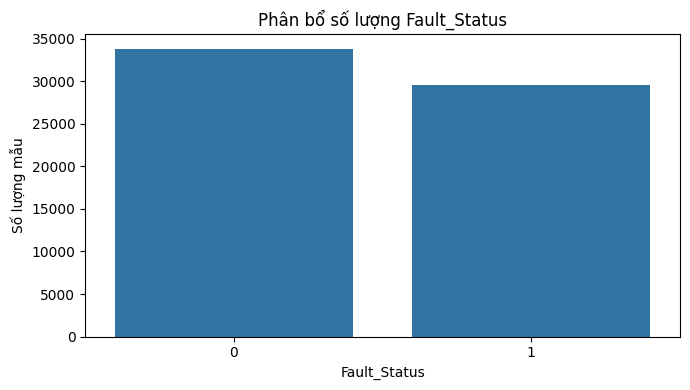

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fault_counts = df_merged['Fault_Status'].value_counts().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=fault_counts.index.astype(str), y=fault_counts.values)
plt.xlabel('Fault_Status')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ số lượng Fault_Status')
plt.tight_layout()
plt.show()


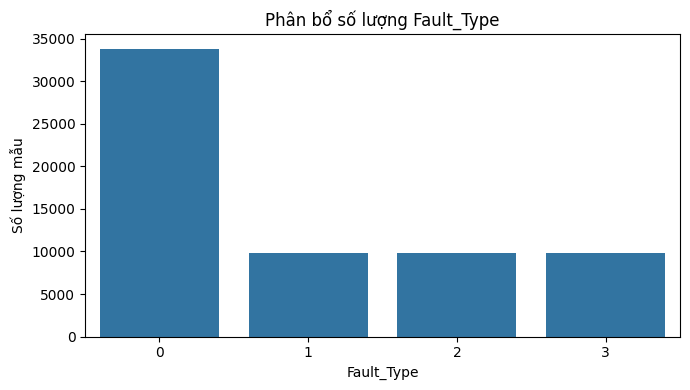

In [30]:
fault_counts = df_merged['Fault_Type'].value_counts().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=fault_counts.index.astype(str), y=fault_counts.values)
plt.xlabel('Fault_Type')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ số lượng Fault_Type')
plt.tight_layout()
plt.show()

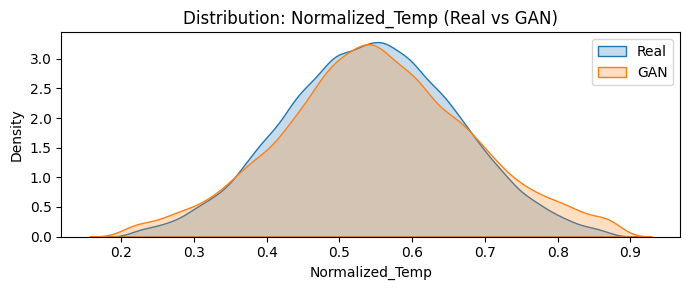

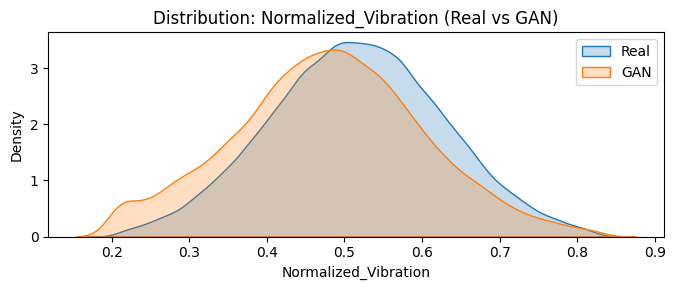

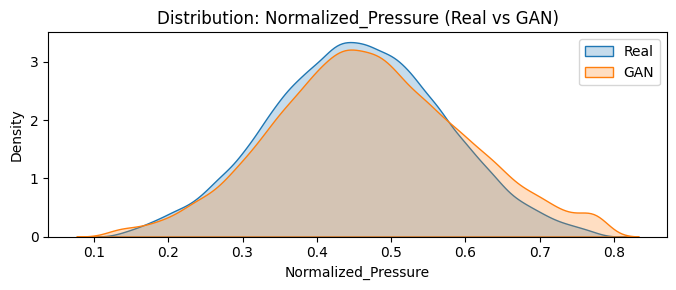

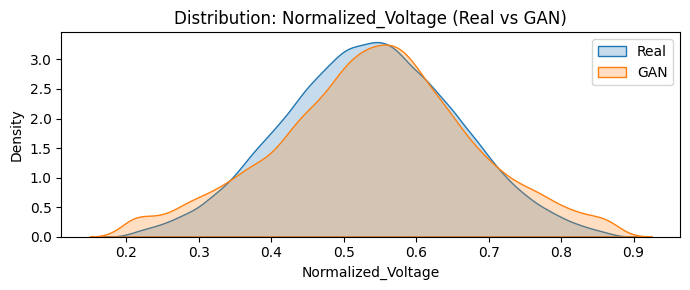

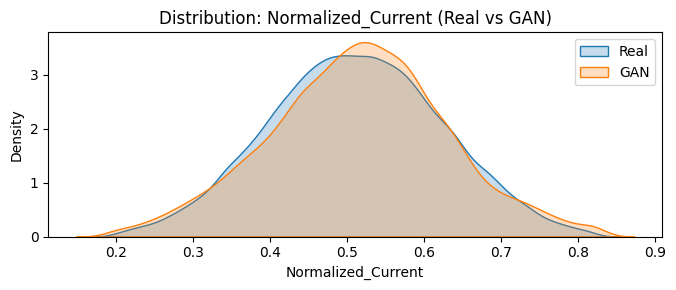

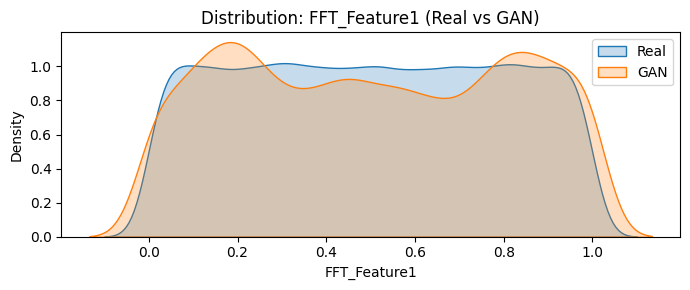

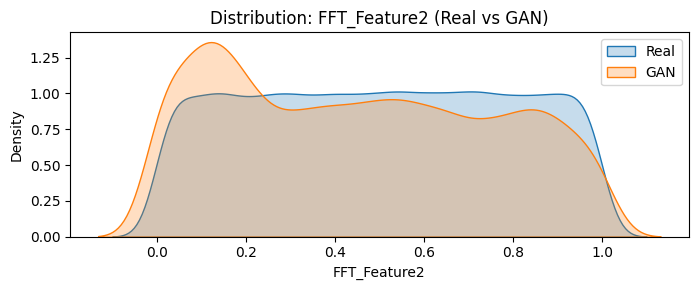

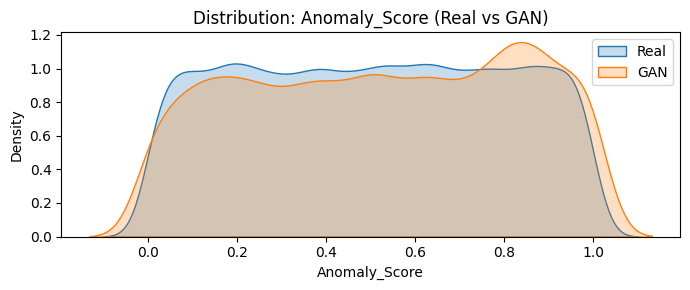

In [31]:
# 5. PHÂN TÍCH & TRỰC QUAN HÓA
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
## 5.1. So sánh phân phối từng feature (Distribution)
for col in sensor_cols:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df_real[col], label='Real', fill=True)
    sns.kdeplot(df_gan[col], label='GAN', fill=True)
    plt.title(f'Distribution: {col} (Real vs GAN)')
    plt.legend()
    plt.tight_layout()
    plt.show()

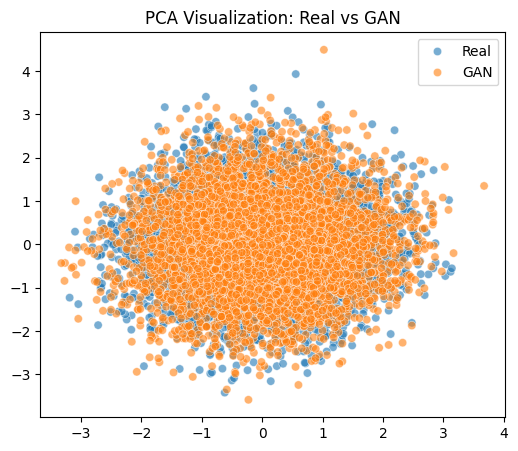

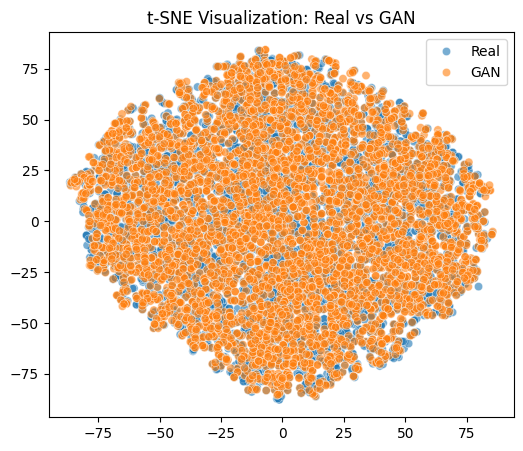

In [32]:
## 5.2. PCA & t-SNE (lấy sample nhỏ để t-SNE nhanh)
n_vis = 5000
real_idx = np.random.choice(df_real.index, size=min(n_vis, len(df_real)), replace=False)
gan_idx = np.random.choice(df_gan.index, size=min(n_vis, len(df_gan)), replace=False)
real_scaled = StandardScaler().fit_transform(df_real.loc[real_idx, sensor_cols])
gan_scaled = StandardScaler().fit_transform(df_gan.loc[gan_idx, sensor_cols])
combined = np.vstack([real_scaled, gan_scaled])
labels = np.array(['Real'] * len(real_idx) + ['GAN'] * len(gan_idx))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, alpha=0.6)
plt.title("PCA Visualization: Real vs GAN")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, alpha=0.6)
plt.title("t-SNE Visualization: Real vs GAN")
plt.show()

In [37]:
## 5.3. KL & JS Divergence
def compute_kl_js(real, fake):
    kl_div = entropy(real + 1e-9, fake + 1e-9)
    js_div = jensenshannon(real + 1e-9, fake + 1e-9) ** 2
    return kl_div, js_div

results = []
for col in sensor_cols:
    real_hist, bins = np.histogram(df_real[col], bins=50, range=(df_real[col].min(), df_real[col].max()), density=True)
    fake_hist, _ = np.histogram(df_gan[col], bins=bins, density=True)
    kl, js = compute_kl_js(real_hist, fake_hist)
    results.append({"Feature": col, "KL_Divergence": kl, "JS_Divergence": js})

div_df = pd.DataFrame(results)
print("\n=== KL & JS Divergence between Real and GAN Data ===")
print(div_df.to_string(index=False))


=== KL & JS Divergence between Real and GAN Data ===
             Feature  KL_Divergence  JS_Divergence
     Normalized_Temp       0.017706       0.004974
Normalized_Vibration       0.058878       0.015988
 Normalized_Pressure       0.020817       0.005968
  Normalized_Voltage       0.025802       0.007341
  Normalized_Current       0.009232       0.002457
        FFT_Feature1       0.029460       0.007833
        FFT_Feature2       0.033842       0.008888
       Anomaly_Score       0.022973       0.006130
